In this program, the generated split data sets (training, validation and test) are used, to train the predictive models.

In [1]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import timeit
import seaborn as sns
sns.set_theme(style="darkgrid")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from keras import backend as K #for custom activation functions

In [2]:
# constants 
T_c = 2 / (math.log(1 + math.sqrt(2)))
temperatures = np.array([1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, T_c, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 3.0, 3.5])

cpath = os.getcwd()
ppath = os.path.abspath(os.path.join(cpath, os.pardir))

#### Read Training, Validation and Test Data

In [3]:
# size of the Ising model lattice
n=40 
# subfolder of the parren path in which the data sets are stored (also multiple layers of subfolders are possible)
# here: parrent_folder -> spin_configurations -> 01_data_split -> samplesize_32000
foldername = 'spin_configurations/01_data_split/samplesize_32000';

training_features_filename = 'training_features_'+str(n)+'.txt'
training_features_filepath = os.path.join(ppath, foldername, training_features_filename)
training_features = np.genfromtxt(training_features_filepath, dtype='int', delimiter=',')

training_phases_filename = 'training_phases_'+str(n)+'.txt'
training_phases_filepath = os.path.join(ppath, foldername,training_phases_filename)
training_phases = np.genfromtxt(training_phases_filepath, dtype='int', delimiter=',')

training_temperatures_filename = 'training_temperatures_'+str(n)+'.txt'
training_temperatures_filepath = os.path.join(ppath, foldername,training_temperatures_filename)
training_temperatures = np.genfromtxt(training_temperatures_filepath, dtype='int', delimiter=',')

training_magnetizations_filename = 'training_magnetizations_'+str(n)+'.txt'
training_magnetizations_filepath = os.path.join(ppath, foldername, training_magnetizations_filename)
training_magnetizations = np.abs(np.genfromtxt(training_magnetizations_filepath, dtype='float', delimiter=','))


validation_features_filename = 'validation_features_'+str(n)+'.txt'
validation_features_filepath = os.path.join(ppath, foldername,validation_features_filename)
validation_features = np.genfromtxt(validation_features_filepath, dtype='int', delimiter=',')

validation_phases_filename = 'validation_phases_'+str(n)+'.txt'
validation_phases_filepath = os.path.join(ppath, foldername,validation_phases_filename)
validation_phases = np.genfromtxt(validation_phases_filepath, dtype='int', delimiter=',')

validation_temperatures_filename = 'validation_temperatures_'+str(n)+'.txt'
validation_temperatures_filepath = os.path.join(ppath, foldername,validation_temperatures_filename)
validation_temperatures = np.genfromtxt(validation_temperatures_filepath, dtype='int', delimiter=',')

validation_magnetizations_filename = 'validation_magnetizations_'+str(n)+'.txt'
validation_magnetizations_filepath = os.path.join(ppath, foldername, validation_magnetizations_filename)
validation_magnetizations = np.abs(np.genfromtxt(validation_magnetizations_filepath, dtype='float', delimiter=','))


test_features_filename = 'test_features_'+str(n)+'.txt'
test_features_filepath = os.path.join(ppath, foldername, test_features_filename)
test_features = np.genfromtxt(test_features_filepath, dtype='int', delimiter=',')

test_phases_filename = 'test_phases_'+str(n)+'.txt'
test_phases_filepath = os.path.join(ppath, foldername,test_phases_filename)
test_phases = np.genfromtxt(test_phases_filepath, dtype='int', delimiter=',')

test_temperatures_filename = 'test_temperatures_'+str(n)+'.txt'
test_temperatures_filepath = os.path.join(ppath, foldername,test_temperatures_filename)
test_temperatures = np.genfromtxt(test_temperatures_filepath, dtype='int', delimiter=',')

test_magnetizations_filename = 'test_magnetizations_'+str(n)+'.txt'
test_magnetizations_filepath = os.path.join(ppath, foldername, test_magnetizations_filename)
test_magnetizations = np.abs(np.genfromtxt(test_magnetizations_filepath, dtype='float', delimiter=','))

## Phase Prediction (Classification)

#### Prepare Data

In [11]:
training_labels = to_categorical(training_phases)
validation_labels = to_categorical(validation_phases)
test_labels = to_categorical(test_phases)

training_features_2d = np.reshape(training_features, (-1,n,n,1))
validation_features_2d = np.reshape(validation_features, (-1,n,n,1))
test_features_2d = np.reshape(test_features, (-1,n,n,1))

#### DNN
First attempt to classify the phases with a dense neural network

In [4]:
# setting up the model and training the model

learning_rate = 0.001
no_epochs = 100
batch_size = 30
hidden_nodes = 30

print("Create DNN ...")
model1 = keras.Sequential(
    [
        keras.Input(shape=(n*n,)),
        layers.Dense(hidden_nodes, activation="relu"),
        layers.Dense(2, activation="softmax"),
    ]
)

#model.summary()#
print("Compile DNN ...")
model1.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    #optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)

print("Fit DNN on training data ...")
history1 = model1.fit(
    training_features,
    training_labels,
    batch_size=batch_size,
    epochs=no_epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(validation_features, validation_labels),
    verbose=0
)

print("finished.")

Create DNN ...
Compile DNN ...
Fit DNN on training data ...


2022-06-22 17:27:53.301915: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 17:27:53.388769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


finished.


last validation accuracy: 0.9379166960716248


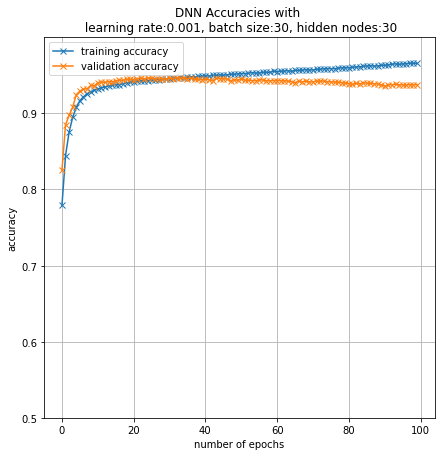

In [5]:
## plot results

print("last validation accuracy: "+ str(history1.history['val_categorical_accuracy'][-1]))

fig, axis = plt.subplots(1, figsize=(7,7))

epochs = np.array(range(len(history1.history['categorical_accuracy'])))
axis.plot(epochs, history1.history['categorical_accuracy'], 'x-', label='training accuracy')
axis.plot(epochs, history1.history['val_categorical_accuracy'], 'x-', label='validation accuracy')

title = "DNN Accuracies with \n learning rate:" +str(learning_rate)+ ", batch size:" +str(batch_size)+ ", hidden nodes:"+str(hidden_nodes)
axis.set(title=title, xlabel='number of epochs',ylabel='accuracy', ylim=(0.5,1))
axis.legend()



major_ticks_y = np.arange(0.5, 1, 0.1)
axis.set_yticks(major_ticks_y)

axis.grid(True, which='major')
plt.show()

##### Accuracy over Temperature

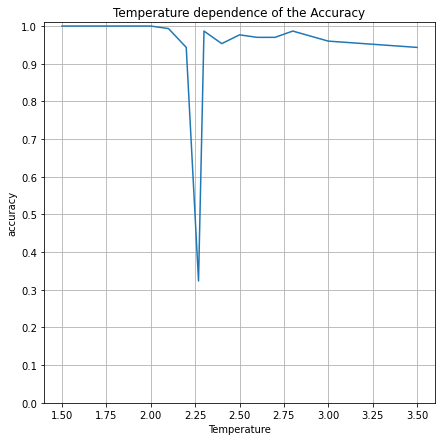

In [6]:
# avaluate accuracies for each temperature
no_classes = 16
categorical_accuracies_dnn = np.zeros(no_classes)
for i in range(no_classes):
    idcs = np.where(validation_temperatures == i)[0]

    categorical_accuracies_dnn[i] = model1.evaluate(
        x=validation_features[idcs],
        y=validation_labels[idcs],
        batch_size=batch_size,
        verbose=0,
        sample_weight=None,
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
        return_dict=True
    )['categorical_accuracy']
    
#print(categorical_accuracies)

fig, axis = plt.subplots(1, figsize=(7,7))
title = "Temperature dependence of the Accuracy"

axis.set(title=title, xlabel='Temperature',ylabel='accuracy', ylim=(0,1.01))

#major_ticks_x = np.arange(0, 151, 20)
major_ticks_y = np.arange(0, 1.01, 0.1)
#axis.set_xticks(major_ticks_x)
axis.set_yticks(major_ticks_y)

axis.grid(True, which='major')
axis.plot(temperatures,categorical_accuracies_dnn, label='training accuracy')
plt.show()

#### CNN
First attempt to classify the phases with a convolutional neural network

In [6]:
# setting up the model and training the model

learning_rate = 0.005
no_epochs = 100
batch_size = 200
conv_filters = 8
kernel_size = 8
print("Create CNN ...")
model2 = keras.Sequential(
    [
        keras.Input(shape=(n,n,1)),
        layers.Conv2D(conv_filters, kernel_size=kernel_size, activation='relu'),
        layers.Flatten(),
        #layers.Dense(20, activation="relu"),
        layers.Dense(2, activation="softmax"),
    ]
)

model2.summary()


print("Compile CNN ...")
model2.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    #optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)

print("Fit CNN on training data ...")
history2 = model2.fit(
    training_features_2d,
    training_labels,
    batch_size=batch_size,
    epochs=no_epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(validation_features_2d, validation_labels),
    verbose=0
)

print("finished.")

Create CNN ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 8)         520       
_________________________________________________________________
flatten (Flatten)            (None, 8712)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 17426     
Total params: 17,946
Trainable params: 17,946
Non-trainable params: 0
_________________________________________________________________
Compile CNN ...
Fit CNN on training data ...


2022-09-06 14:04:45.561995: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-06 14:04:45.652248: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


finished.


##### Accuracies over number of Epochs

last validation accuracy: 0.9599999785423279


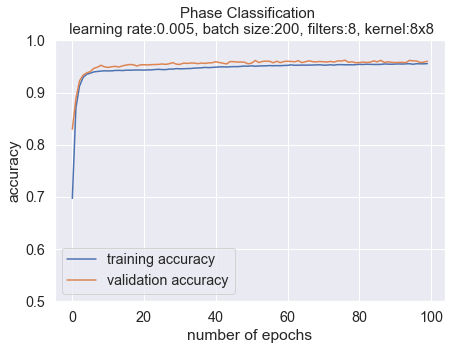

In [7]:
## plot results
print("last validation accuracy: "+ str(history2.history['val_categorical_accuracy'][-1]))

epochs = np.array(range(len(history2.history['categorical_accuracy'])))
sns.set(font_scale=1.3)
fig, axis = plt.subplots(1, figsize=(7,4.8))

sns.lineplot(x=epochs, y=history2.history['categorical_accuracy'], ax=axis, label='training accuracy')
sns.lineplot(x=epochs, y=history2.history['val_categorical_accuracy'], ax=axis, label='validation accuracy')

title = "Phase Classification \n learning rate:" +str(learning_rate)+ ", batch size:" +str(batch_size)+ ", filters:"+str(conv_filters) + ", kernel:"+str(kernel_size)+"x"+str(kernel_size)
axis.set_title(title,fontsize=15)
axis.set(xlabel='number of epochs',ylabel='accuracy', ylim=(0.5,1))
#major_ticks_x = np.arange(0, 151, 20)
major_ticks_y = np.arange(0.5, 1.01, 0.1)
#axis.set_xticks(major_ticks_x)
axis.set_yticks(major_ticks_y)
axis.grid(True, which='major')
axis.legend()
plt.show()

##### Test Accuracy

In [12]:

test_accuracy = model2.evaluate(
        x=test_features_2d,
        y=test_labels,
        batch_size=batch_size,
        verbose=0,
        sample_weight=None,
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
        return_dict=True
    )['categorical_accuracy']

test_accuracy

0.9468749761581421

##### Accuracies over Temperature

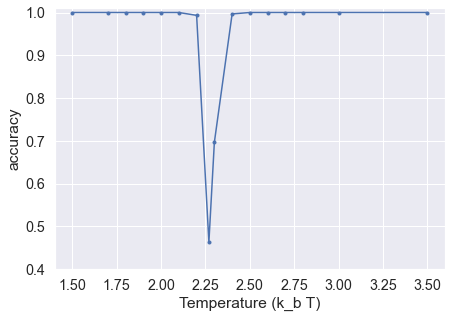

In [34]:
# avaluate accuracies for each temperature
no_classes = 16
categorical_accuracies_cnn = np.zeros(no_classes)
for i in range(no_classes):
    idcs = np.where(test_temperatures == i)[0]

    categorical_accuracies_cnn[i] = model2.evaluate(
        x=test_features_2d[idcs],
        y=test_labels[idcs],
        batch_size=batch_size,
        verbose=0,
        sample_weight=None,
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
        return_dict=True
    )['categorical_accuracy']
    
#print(categorical_accuracies)

fig, axis = plt.subplots(1, figsize=(7,4.8))
#title = "Temperature dependence of the Accuracy"

axis.set(xlabel='Temperature (k_b T)',ylabel='accuracy', ylim=(0.4,1.01))
major_ticks_y = np.arange(0.4, 1.01, 0.1)
axis.set_yticks(major_ticks_y)
axis.grid(True, which='major')
axis.plot(temperatures,categorical_accuracies_cnn, ".-",label='training accuracy')
plt.show()

#### CNN vs DNN
Comparison of the two attempts of classifying the phases

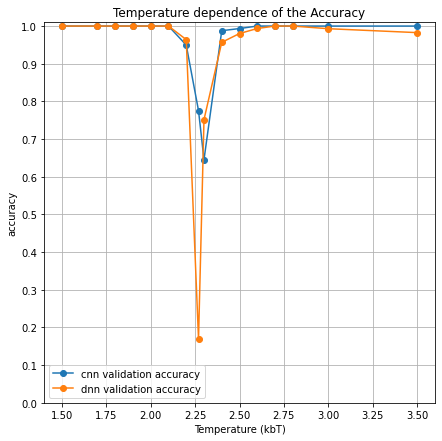

In [48]:
fig, axis = plt.subplots(1, figsize=(7,7))
title = "Temperature dependence of the Accuracy"

axis.set(title=title, xlabel='Temperature (kbT)',ylabel='accuracy', ylim=(0,1.01))

axis.plot(temperatures,categorical_accuracies_cnn, '-o', label='cnn validation accuracy')
axis.plot(temperatures,categorical_accuracies_dnn, '-o',label='dnn validation accuracy')
major_ticks_y = np.arange(0, 1.01, 0.1)
axis.set_yticks(major_ticks_y)
axis.grid(True, which='major')
axis.legend()

plt.show()

## Temperature Prediction

### Temperature Classification
First attempt was to predict the temperature as a classifcation task, with poor results

In [4]:
no_classes = 16

#### Prepare Data

In [5]:

training_temperatures_categorical = to_categorical(training_temperatures)
validation_temperatures_categorical = to_categorical(validation_temperatures)

#reshape features to be 2 dimensional
training_features_2d = np.reshape(training_features, (-1,n,n,1))
validation_features_2d = np.reshape(validation_features, (-1,n,n,1))

In [6]:
# Convolutional NN

# learning rate for SGD algorithm
learning_rate = 0.001
# 
no_epochs = 50
# number of samples that are propagated through the network for one update step
batch_size = 200
conv_filters = 4
kernel_size = 8
dense_nodes=10

print("Create CNN ...")
model3 = keras.Sequential(
    [
        keras.Input(shape=(n,n,1)),
        layers.Conv2D(conv_filters, kernel_size=kernel_size, activation='relu'),
        #layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same"),
        
        layers.Flatten(),
        #layers.Dense(dense_nodes, activation="relu"),
        layers.Dense(no_classes, activation="softmax"),
    ]
)

model3.summary()

print("Compile CNN ...")
model3.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    #optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)

print("Fit CNN on training data ...")
history3 = model3.fit(
    training_features_2d,
    training_temperatures_categorical,
    batch_size=batch_size,
    epochs=no_epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(validation_features_2d, validation_temperatures_categorical),
    verbose=1
)

print("finished.")





Create CNN ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 4)         260       
_________________________________________________________________
flatten (Flatten)            (None, 4356)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                69712     
Total params: 69,972
Trainable params: 69,972
Non-trainable params: 0
_________________________________________________________________
Compile CNN ...
Fit CNN on training data ...
Epoch 1/50


2022-09-06 12:58:14.712998: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-06 12:58:14.797364: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


112/112 [==============================] - 5s 42ms/step - loss: 2.7986 - categorical_accuracy: 0.0698 - val_loss: 2.7423 - val_categorical_accuracy: 0.0754
Epoch 2/50
112/112 [==============================] - 5s 40ms/step - loss: 2.7444 - categorical_accuracy: 0.0759 - val_loss: 2.7375 - val_categorical_accuracy: 0.0750
Epoch 3/50
112/112 [==============================] - 5s 40ms/step - loss: 2.7403 - categorical_accuracy: 0.0768 - val_loss: 2.7279 - val_categorical_accuracy: 0.0881
Epoch 4/50
112/112 [==============================] - 5s 43ms/step - loss: 2.7328 - categorical_accuracy: 0.0705 - val_loss: 2.7131 - val_categorical_accuracy: 0.0829
Epoch 5/50
112/112 [==============================] - 5s 40ms/step - loss: 2.7094 - categorical_accuracy: 0.0852 - val_loss: 2.6863 - val_categorical_accuracy: 0.0962
Epoch 6/50
112/112 [==============================] - 5s 42ms/step - loss: 2.6797 - categorical_accuracy: 0.0939 - val_loss: 2.6616 - val_categorical_accuracy: 0.1058
Epoch 7/5

KeyboardInterrupt: 

last validation accuracy: 0.2433333396911621


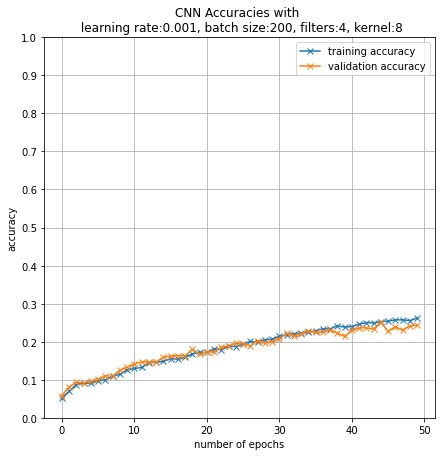

In [57]:
## plot results
print("last validation accuracy: "+ str(history3.history['val_categorical_accuracy'][-1]))

fig, axis = plt.subplots(1, figsize=(7,7))

epochs = np.array(range(len(history3.history['categorical_accuracy'])))
axis.plot(epochs, history3.history['categorical_accuracy'], 'x-', label='training accuracy')
axis.plot(epochs, history3.history['val_categorical_accuracy'], 'x-', label='validation accuracy')

title = "CNN Accuracies with \n learning rate:" +str(learning_rate)+ ", batch size:" +str(batch_size)+ ", filters:"+str(conv_filters)+", kernel:" +str(kernel_size)
axis.set(title=title, xlabel='number of epochs',ylabel='accuracy', ylim=(0,1))
major_ticks_y = np.arange(0, 1.01, 0.1)
axis.set_yticks(major_ticks_y)
axis.grid(True, which='major')
axis.legend()
plt.show()

##### Accuracies over Temperature

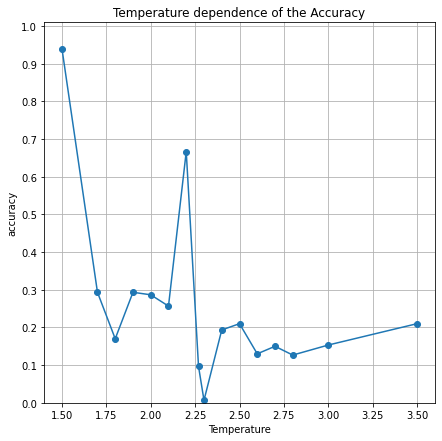

In [23]:
# avaluate accuracies for each temperature
no_classes = 16
categorical_accuracies_temp = np.zeros(no_classes)
for i in range(no_classes):
    idcs = np.where(validation_temperatures_categorical == i)[0]

    categorical_accuracies_temp[i] = model3.evaluate(
        x=validation_features_2d[idcs],
        y=validation_temperatures_categorical[idcs],
        batch_size=batch_size,
        verbose=0,
        sample_weight=None,
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
        return_dict=True
    )['categorical_accuracy']
    
#print(categorical_accuracies)

fig, axis = plt.subplots(1, figsize=(7,7))
title = "Temperature dependence of the Accuracy"

axis.set(title=title, xlabel='Temperature',ylabel='accuracy',  ylim=(0,1.01))
major_ticks_y = np.arange(0, 1.01, 0.1)
axis.set_yticks(major_ticks_y)
axis.grid(True, which='major')
axis.plot(temperatures,categorical_accuracies_temp,'-o', label='training accuracy')
plt.show()

### Temperature Regression
Second attempt to predict the temperature as a regression task, with better results

In [77]:
# preparing data

training_temperatures_float = temperatures[training_temperatures]
validation_temperatures_float = temperatures[validation_temperatures]
test_temperatures_float = temperatures[test_temperatures]


In [93]:
# setting up the model and training the model

no_epochs = 100
batch_size= 100
learning_rate=0.001


def mySinFunction(x):
    return K.sin(x)


model4 = keras.Sequential([
    keras.Input(shape=(1600,)),
    layers.Dense(256, kernel_initializer='random_normal', activation='relu'),
    layers.Dense(128, kernel_initializer='random_normal', activation='tanh'),
    layers.Dense(128, kernel_initializer='random_normal', activation=mySinFunction),
    layers.Dense(1, activation='linear')
])

#msle = MeanSquaredLogarithmicError()
model4.compile( loss='mean_squared_error', 
                optimizer=tf.keras.optimizers.Adam(learning_rate)
                #metrics=[keras.metrics.CategoricalAccuracy()]
              )

model4.summary()

history4 = model4.fit(
    training_features,
    training_temperatures_float,
    epochs=no_epochs,
    batch_size=batch_size,
    validation_data=(validation_features, validation_temperatures_float),
    verbose=0 
    )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               409856    
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_31 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 459,393
Trainable params: 459,393
Non-trainable params: 0
_________________________________________________________________


last validation loss: 0.041287411004304886


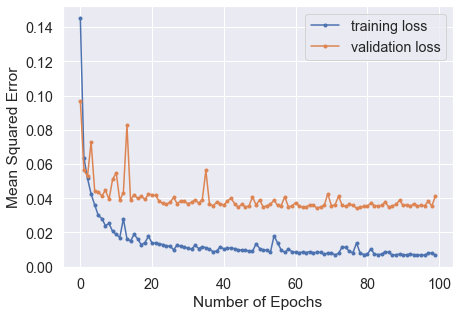

In [94]:
## plot results
print("last validation loss: "+ str(history4.history['val_loss'][-1]))

fig, axis = plt.subplots(1, figsize=(7,4.8))

epochs = np.array(range(len(history4.history['val_loss'])))

'''
avg_train_loss = np.zeros(len(history4.history['loss']))
avg_val_loss = np.zeros(len(history4.history['val_loss']))


for i in range(len(history4.history['loss'])):
    avg_train_loss[i] = np.mean(history4.history['loss'][0:i])

for i in range(len(history4.history['val_loss'])):
    avg_val_loss[i] = np.mean(history4.history['val_loss'][0:i])
'''

axis.plot(epochs, history4.history['loss'], '.-', label='training loss')
axis.plot(epochs, history4.history['val_loss'], '.-', label='validation loss')

title = "Mean Squared Error"
axis.set(xlabel='Number of Epochs',ylabel='Mean Squared Error') 
#major_ticks_y = np.arange(0, 0.51, 0.1)
#axis.set_yticks(major_ticks_y)
axis.grid(True, which='major')
axis.legend()
plt.show()


In [1]:
# results of the test set
test_temperatures_predicted = model4.predict(test_features)
test_temperatures_predicted = np.reshape(test_temperatures_predicted,-1)
test_mse_temperature = np.mean(np.square(test_temperatures_predicted - test_temperatures_float))
print("tempaerture NRMSE: ",np.sqrt(test_mse_temperature) / np.mean(temperatures[test_temperatures]))

NameError: name 'model4' is not defined

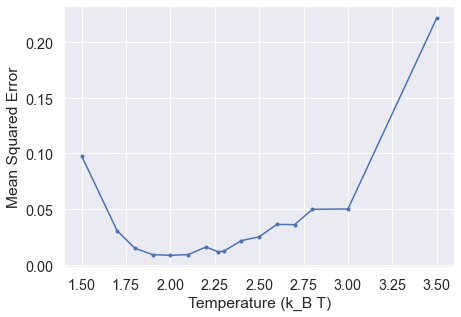

In [96]:
# result over different temperatures

mse = np.ones(len(temperatures))
# avaluate accuracies for each temperature

categorical_accuracies_temp = np.zeros(len(temperatures))
for i,kbT in enumerate(temperatures):
    idcs = np.where(test_temperatures == i)[0]
    mse[i] = np.mean(np.square(test_temperatures_predicted[idcs] - test_temperatures_float[idcs]))
    

fig, axis = plt.subplots(1, figsize=(7,4.8))
#title = "Temperature dependence of the MSE"

plt.ticklabel_format(useMathText = True)

axis.set(xlabel='Temperature (k_B T)',ylabel='Mean Squared Error')
#major_ticks_y = np.arange(0, 1.01, 0.1)
#axis.set_yticks(major_ticks_y)
axis.grid(True, which='major')
axis.plot(temperatures,mse,'.-', label='validation MSE')
plt.show()

## Magnetization Prediction (Regression)

In [83]:
# setting up the model and training the model

no_epochs = 100
batch_size= 100
learning_rate=0.002

model5 = keras.Sequential([
    keras.Input(shape=(1600,)),
    layers.Dense(128, kernel_initializer='random_normal', activation='relu'),
    layers.Dense(128, kernel_initializer='random_normal', activation='relu'),
    layers.Dense(256, kernel_initializer='random_normal', activation='relu'),
    layers.Dense(1, activation='linear')
])

#msle = MeanSquaredLogarithmicError()
model5.compile( loss='mean_squared_error', 
                optimizer=tf.keras.optimizers.Adam(learning_rate)
                #metrics=[keras.metrics.CategoricalAccuracy()]
              )

model5.summary()

history5 = model5.fit(
    training_features,
    training_magnetizations,
    epochs=no_epochs,
    batch_size=batch_size,
    validation_data=(validation_features, validation_magnetizations),
    verbose=0 
    )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 257       
Total params: 254,721
Trainable params: 254,721
Non-trainable params: 0
_________________________________________________________________


last validation loss: 4.465437996259425e-06


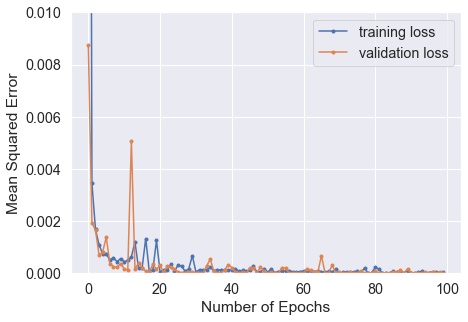

In [84]:
## plot results
print("last validation loss: "+ str(history5.history['val_loss'][-1]))

fig, axis = plt.subplots(1, figsize=(7,4.8))

epochs = np.array(range(len(history5.history['val_loss'])))
axis.plot(epochs, history5.history['loss'], '.-', label='training loss')
axis.plot(epochs, history5.history['val_loss'], '.-', label='validation loss')

#title = "Mean Squared Error"
axis.set(xlabel='Number of Epochs',ylabel='Mean Squared Error', ylim=(0,0.01)) 
#major_ticks_y = np.arange(0, 1.01, 0.1)
#axis.set_yticks(major_ticks_y)
axis.grid(True, which='major')
axis.legend()
plt.show()

##### Test MSE

In [85]:
test_magnetizations_predicted = model5.predict(test_features)
test_magnetizations_predicted = np.reshape(test_magnetizations_predicted,-1)
test_mse_magnetization = np.mean(np.square(test_magnetizations_predicted - test_magnetizations))

print("magnetization NRMSE: ",np.sqrt(test_mse_magnetization) / np.mean(test_magnetizations))

4.530246656298594e-06

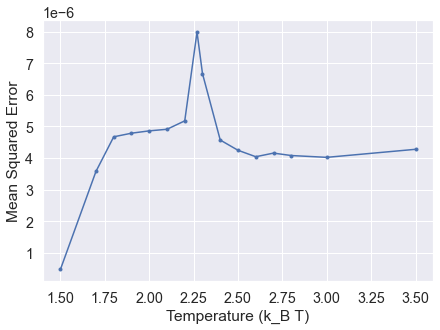

In [97]:
mse_magnetization = np.ones(len(temperatures))
for i,kbT in enumerate(temperatures):
    idcs = np.where(test_temperatures == i)[0]
    mse_magnetization[i] = np.mean(np.square(test_magnetizations_predicted[idcs] - test_magnetizations[idcs]))

fig, axis = plt.subplots(1, figsize=(7,4.8))
#title = "Temperature dependence of the MSE"

#plt.ticklabel_format(useMathText = True)

axis.set(xlabel='Temperature (k_B T)',ylabel='Mean Squared Error')
#major_ticks_y = np.arange(0, 1.01, 0.1)
#axis.set_yticks(major_ticks_y)
axis.grid(True, which='major')
axis.plot(temperatures,mse_magnetization,'.-', label='validation MSE')
plt.show()

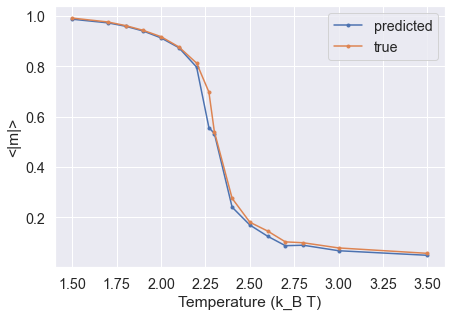

In [92]:

magnetization_means_true = [0.9917562500000011,
                            0.9763249999999991,
                            0.9619500000000006,
                            0.9428687499999999,
                            0.9177875000000004,
                            0.8771312499999999,
                            0.8126937499999997,
                            0.6977812500000001,
                            0.5401812500000002,
                            0.2751312499999999,
                            0.18007499999999993,
                            0.14511875000000007,
                            0.10204375000000003,
                            0.09856875000000005,
                            0.07796249999999995,
                            0.05645625000000003]


magnetization_means_predicted = np.ones(len(temperatures))
for i,kbT in enumerate(temperatures):
    idcs = np.where(test_temperatures == i)[0]
    magnetization_means_predicted[i] = np.mean(test_magnetizations_predicted[idcs])


fig, axis = plt.subplots(1, figsize=(7,4.8))
axis.set(xlabel='Temperature (k_B T)',ylabel='<|m|>') 
axis.grid(True, which='major')

axis.plot(temperatures, magnetization_means_predicted,".-", label='predicted')
axis.plot(temperatures, magnetization_means_true,".-", label='true')
axis.legend()
plt.show()